In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Загружаем данные
df = pd.read_csv("/content/gdrive/My Drive/data_half_price.csv")

# Убираем выбросы (как в первой модели)
df = df[(df['Price'] >= 500_000) & (df['Price'] <= 200_000_000)]
df = df[(df['Area'] >= 15) & (df['Area'] <= 300)]
df = df[df['Floor'] <= df['Number of floors']]
df = df.dropna()

# Признаки
numeric_features = ['Area', 'Living area', 'Kitchen area', 'Number of rooms',
                    'Minutes to metro', 'Number of floors', 'Floor']

categorical_features = ['Apartment type', 'Metro station', 'Region', 'Renovation']

# Целевая переменная
y = df['Price'].values
X_numeric = df[numeric_features].values

In [4]:
# Создаем энкодеры для каждой категориальной переменной
label_encoders = {}
X_categorical_indices = []

for cat_feature in categorical_features:
    le = LabelEncoder()
    encoded = le.fit_transform(df[cat_feature].astype(str))
    label_encoders[cat_feature] = le
    X_categorical_indices.append(encoded)

# Преобразуем в numpy массив (каждый столбец — индексы для своего признака)
X_categorical = np.column_stack(X_categorical_indices)

print(f"Размерность категориальных данных: {X_categorical.shape}")
print(f"Количество уникальных станций метро: {len(label_encoders['Metro station'].classes_)}")
print(f"Количество уникальных типов ремонта: {len(label_encoders['Renovation'].classes_)}")

Размерность категориальных данных: (20055, 4)
Количество уникальных станций метро: 545
Количество уникальных типов ремонта: 4


In [5]:
# Объединяем все признаки для разделения
X_combined = np.hstack([X_numeric, X_categorical])

# Разделяем
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y, test_size=0.2, random_state=42, shuffle=True
)

# Масштабируем числовые признаки
scaler_numeric = StandardScaler()
X_train_numeric = scaler_numeric.fit_transform(X_train[:, :len(numeric_features)])
X_test_numeric = scaler_numeric.transform(X_test[:, :len(numeric_features)])

# Разделяем обратно на числовые и категориальные части
X_train_cat = X_train[:, len(numeric_features):].astype(int)
X_test_cat = X_test[:, len(numeric_features):].astype(int)

# Масштабируем целевую переменную
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

In [6]:
class EmbeddingModel(nn.Module):
    def __init__(self, numeric_dim, embedding_configs):
        """
        numeric_dim: размерность числовых признаков
        embedding_configs: список кортежей (num_embeddings, embedding_dim)
                          для каждого категориального признака
        """
        super(EmbeddingModel, self).__init__()

        self.embeddings = nn.ModuleList()
        total_embedding_dim = 0
        for num_emb, emb_dim in embedding_configs:
            self.embeddings.append(nn.Embedding(num_emb, emb_dim))
            total_embedding_dim += emb_dim

        combined_dim = numeric_dim + total_embedding_dim

        self.network = nn.Sequential(
            nn.Linear(combined_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.1),

            nn.Linear(64, 1)
        )

    def forward(self, numeric_features, categorical_features):
        """
        numeric_features: тензор числовых признаков [batch_size, numeric_dim]
        categorical_features: тензор категориальных индексов [batch_size, num_cat_features]
        """
        # Проходим каждую категорию через свой эмбеддинг
        embedded_features = []
        for i, emb_layer in enumerate(self.embeddings):
            embedded = emb_layer(categorical_features[:, i])
            embedded_features.append(embedded)

        # Объединяем все эмбеддинги
        all_embedded = torch.cat(embedded_features, dim=1)

        # Объединяем с числовыми признаками
        combined = torch.cat([numeric_features, all_embedded], dim=1)

        # Пропускаем через основную сеть
        return self.network(combined)

In [7]:
# Конфигурация эмбеддингов для каждого признака
# (количество уникальных значений, размерность эмбеддинга)
embedding_configs = [
    (len(label_encoders['Apartment type'].classes_), 4),
    (len(label_encoders['Metro station'].classes_), 16),
    (len(label_encoders['Region'].classes_), 4),
    (len(label_encoders['Renovation'].classes_), 8)
]

# Создаем модель
model = EmbeddingModel(
    numeric_dim=len(numeric_features),
    embedding_configs=embedding_configs
)

# Подготовка данных для PyTorch
X_train_num_tensor = torch.FloatTensor(X_train_numeric)
X_train_cat_tensor = torch.LongTensor(X_train_cat)
y_train_tensor = torch.FloatTensor(y_train_scaled).view(-1, 1)

X_test_num_tensor = torch.FloatTensor(X_test_numeric)
X_test_cat_tensor = torch.LongTensor(X_test_cat)
y_test_tensor = torch.FloatTensor(y_test_scaled).view(-1, 1)

# Функция потерь и оптимизатор
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=20, factor=0.5)

# Обучение
epochs = 300
batch_size = 64
train_size = len(X_train_num_tensor)

train_losses = []
val_losses = []

for epoch in range(epochs):
    # Перемешиваем данные
    indices = torch.randperm(train_size)
    model.train()

    epoch_loss = 0
    for start_idx in range(0, train_size, batch_size):
        end_idx = min(start_idx + batch_size, train_size)
        batch_indices = indices[start_idx:end_idx]

        batch_num = X_train_num_tensor[batch_indices]
        batch_cat = X_train_cat_tensor[batch_indices]
        batch_y = y_train_tensor[batch_indices]

        optimizer.zero_grad()
        outputs = model(batch_num, batch_cat)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * len(batch_indices)

    avg_train_loss = epoch_loss / train_size
    train_losses.append(avg_train_loss)

    # Валидация
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test_num_tensor, X_test_cat_tensor)
        val_loss = criterion(val_outputs, y_test_tensor).item()
        val_losses.append(val_loss)

    scheduler.step(val_loss)

    if (epoch + 1) % 30 == 0:
        print(f"Эпоха {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}")

Эпоха 30/300, Train Loss: 0.1226, Val Loss: 0.1442
Эпоха 60/300, Train Loss: 0.0859, Val Loss: 0.1430
Эпоха 90/300, Train Loss: 0.0777, Val Loss: 0.1337
Эпоха 120/300, Train Loss: 0.0705, Val Loss: 0.1419
Эпоха 150/300, Train Loss: 0.0621, Val Loss: 0.1291
Эпоха 180/300, Train Loss: 0.0554, Val Loss: 0.1323
Эпоха 210/300, Train Loss: 0.0523, Val Loss: 0.1308
Эпоха 240/300, Train Loss: 0.0521, Val Loss: 0.1317
Эпоха 270/300, Train Loss: 0.0476, Val Loss: 0.1322
Эпоха 300/300, Train Loss: 0.0507, Val Loss: 0.1299


In [8]:
# Предсказания на тесте
model.eval()
with torch.no_grad():
    test_pred_scaled = model(X_test_num_tensor, X_test_cat_tensor).numpy()
    test_pred = scaler_y.inverse_transform(test_pred_scaled).flatten()
    actual_prices = y_test

# Метрики
r2 = r2_score(actual_prices, test_pred)
mae = mean_absolute_error(actual_prices, test_pred)
rmse = np.sqrt(mean_squared_error(actual_prices, test_pred))

print("\n" + "="*60)
print("РЕЗУЛЬТАТЫ МОДЕЛИ С ЭМБЕДДИНГАМИ")
print("="*60)
print(f"R² Score: {r2:.4f}")
print(f"MAE: {mae:,.0f} руб.")
print(f"RMSE: {rmse:,.0f} руб.")
print(f"Средняя цена в тесте: {actual_prices.mean():,.0f} руб.")
print(f"Относительная ошибка (MAE/средняя цена): {(mae/actual_prices.mean())*100:.1f}%")
print("="*60)

# Сравнение с первой моделью
print("\nСРАВНЕНИЕ С ПЕРВОЙ МОДЕЛЬЮ (One-Hot):")
print("-"*40)
print("Модель                   |   R²   |   MAE   |  RMSE")
print("-"*40)
print(f"Полносвязная (One-Hot)  | 0.7809 | 4.1M    | 19.1M")
print(f"С эмбеддингами          | {r2:.4f} | {mae/1e6:.1f}M    | {rmse/1e6:.1f}M")
print("-"*40)


РЕЗУЛЬТАТЫ МОДЕЛИ С ЭМБЕДДИНГАМИ
R² Score: 0.8617
MAE: 2,839,135 руб.
RMSE: 8,999,388 руб.
Средняя цена в тесте: 14,341,184 руб.
Относительная ошибка (MAE/средняя цена): 19.8%

СРАВНЕНИЕ С ПЕРВОЙ МОДЕЛЬЮ (One-Hot):
----------------------------------------
Модель                   |   R²   |   MAE   |  RMSE
----------------------------------------
Полносвязная (One-Hot)  | 0.7809 | 4.1M    | 19.1M
С эмбеддингами          | 0.8617 | 2.8M    | 9.0M
----------------------------------------


Text(0.5, 1.0, 'Предсказание vs Реальность')

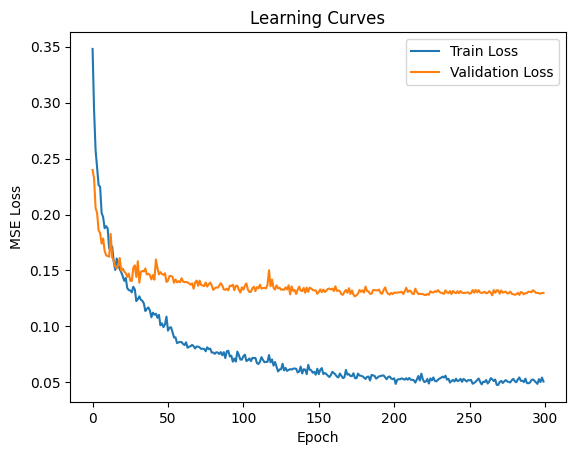

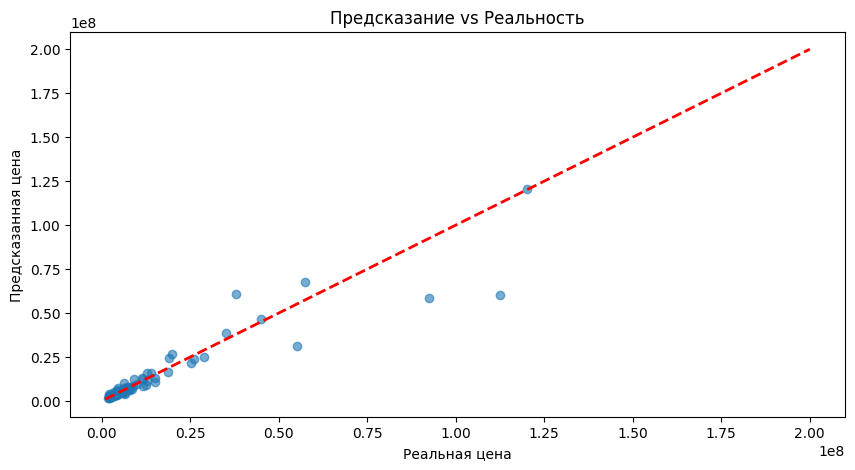

In [12]:
import matplotlib.pyplot as plt
# 1. График потерь при обучении
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()

# 2. Сравнение предсказаний
plt.figure(figsize=(10, 5))
plt.scatter(actual_prices[:100], test_pred[:100], alpha=0.6)
plt.plot([actual_prices.min(), actual_prices.max()],
         [actual_prices.min(), actual_prices.max()], 'r--', lw=2)
plt.xlabel('Реальная цена')
plt.ylabel('Предсказанная цена')
plt.title('Предсказание vs Реальность')